In [77]:
import os
import time

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd
import scipy

import jax
from jax import vmap
import jax.numpy as jnp
import jax.random as random

import numpyro
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS, init_to_feasible, init_to_median, init_to_sample, \
    init_to_uniform, init_to_value

from pymc3.gp.util import plot_gp_dist
import pymc3 as pm
# import pymc3.sampling_jax

import cmdstanpy as stan
import arviz as az

from tqdm import tqdm

In [11]:
# Don't sting my eyes
%config InlineBackend.figure_format = 'retina'
sns.set()

In [12]:
%load_ext stanmagic

The stanmagic extension is already loaded. To reload it, use:
  %reload_ext stanmagic


In [13]:
# Default to double precision.
# numpyro.enable_x64()

# Utility models

In [14]:
def u_pow(x, theta): return x**theta

In [15]:
def u_exp(x, theta): return 1 - np.exp(-theta*x)

In [16]:
def u_lin(x, theta=None): return x

# Generate choice data

In [17]:
def generate_data(u, seed=123, max_x=1, n=100, tau=3.333, theta=0.5):
    
    np.random.seed(seed)
    
    data = pd.DataFrame(np.random.uniform(0, 1, size=(n*10, 4)), columns=["p0", "x0", "p1", "x1"])
    for i in range(2):
        data[f"x{i}"] = data[f"x{i}"].values * max_x
    data = data[~((data.p0 >= data.p1) & (data.x0 >= data.x1))]
    data = data[~((data.p1 >= data.p0) & (data.x1 >= data.x0))]
    data = data.sample(n=n, replace=False)
    
    p0 = data.p0.values
    p1 = data.p1.values
    x0 = data.x0.values
    x1 = data.x1.values
    
    seu0 = p0 * u(x0, theta)
    seu1 = p1 * u(x1, theta)

    diff_eu = seu1 - seu0

    p_choice_1 = scipy.special.expit(tau*diff_eu)
    choices = np.zeros(n, dtype=int)
    choices[:] = p_choice_1 > np.random.random(size=n)
    data['choices'] = choices

    return data

In [18]:
data = generate_data(u=u_pow, n=1000, tau=3.333, theta=(0.5, ))
data

,p0,x0,p1,x1,choices
9002,0.696389,0.007647,0.617248,0.282997,1
7863,0.953285,0.292898,0.380948,0.552913,1
7455,0.060678,0.327938,0.685627,0.158464,1
3414,0.138550,0.276750,0.788651,0.125342,0
5796,0.116159,0.356232,0.732859,0.310642,0
...,...,...,...,...,...
2857,0.928569,0.159319,0.006656,0.571188,0
5417,0.621396,0.103035,0.601608,0.871169,1
1854,0.218694,0.560962,0.389658,0.026879,1
8834,0.980679,0.073375,0.877985,0.777087,1


# Likelihood whole model given M, $\theta_M$

In [19]:
def softplus(x):
    return np.log(1 + np.exp(x))

def objective(param, data, u_m):
    
    param = softplus(param)  # All parameters all supposed to be R+
    
    tau = param[0]
    theta = param[1]
    
    p0 = data.p0.values
    p1 = data.p1.values
    x0 = data.x0.values
    x1 = data.x1.values
    y = data.choices.values 
    
    seu0 = p0 * u_m(x0, theta)
    seu1 = p1 * u_m(x1, theta)

    diff_eu = seu1 - seu0

    p_choice_1 = scipy.special.expit(tau*diff_eu) # p choose 1
    p_choice_y = p_choice_1**y * (1-p_choice_1)**(1-y)
    return - np.log(p_choice_y).sum()

In [20]:
def optimize(data, u_m=u_pow, x0=None):
    if x0 is None:
        x0 = (0.0, 0.0) # Assume two parameters
    opt = scipy.optimize.minimize(objective, x0=x0, args=(data, u_m))
    return softplus(opt.x)

In [21]:
optimize(data, u_m=u_pow)

array([3.28496491, 0.53506426])

# Measure discrepancy

## Generate data

In [69]:
u_data = u_pow
theta_data = 0.5
tau_data = 3.333

In [70]:
data = generate_data(u=u_data, tau=tau_data, theta=theta_data, n=1000, seed=123)
np.random.seed(12345)
data = data.sample(n=100, replace=False)

In [71]:
optimize(data, u_m=u_pow)

array([3.4444072 , 0.39557323])

In [128]:
%%stan -f gp_model.stan -v gp_model --stanc ~/.cmdstan/cmdstan-2.26.1/bin/stanc
data {
  int<lower=0> N;
  int<lower=0> N_y;
  vector<lower=0, upper=1>[N] p;
  vector[N] x;
  int<lower=0, upper=1> y[N_y];
  int belong0[N_y];
  int belong1[N_y];
  real theta;
  real tau;
  real jitter;
  vector[N] mu;
}
transformed data {
  matrix[N, N] diag_jitter;
  diag_jitter = diag_matrix(rep_vector(jitter, N));
}
parameters {
  real<lower=0> kernel_length;
  real<lower=0> kernel_var; 
  vector[N] eta;
}
transformed parameters{
}
model {
  vector[N] seu;
  vector[N_y] seu0;
  vector[N_y] seu1;
  vector[N_y] diff_eu;
  matrix[N, N] L;
  matrix[N, N] K;
  vector[N] f;
  
  kernel_length ~ lognormal(0, 10);
  kernel_var ~ lognormal(0, 10);
  eta ~ std_normal();
  
  K = gp_exp_quad_cov(to_array_1d(x), kernel_var, kernel_length) + diag_jitter;
  L = cholesky_decompose(K);
  
  f = mu + L*eta;
  
  seu = p .* f;
  seu0 = seu[belong0];
  seu1 = seu[belong1];
  diff_eu = seu1 - seu0;
  y ~ bernoulli_logit(tau * diff_eu);
}
generated quantities {
}

Using stanc compiler:  ~/.cmdstan/cmdstan-2.26.1/bin/stanc
~/.cmdstan/cmdstan-2.26.1/bin/stanc --o=/var/folders/yg/spp3n_c56vxbgvjy9wthwy_h0000gn/T/b6e3cf9c-e8b7-4142-8869-959c87d463ea.cpp gp_model.stan

-------------------------------------------------------------------------------
Model compiled successfully. Output stored in model object.
Type model in a cell to see a nicely formatted code output in a notebook
     ^^^^^
Access model compile output properties
model.model_file -> Name of stan_file [gp_model.stan]
model.model_name -> Name of stan model [gp_model_model]
model.model_code -> Model code [data {   int<lower=0 ....]


In [133]:
def prepare_data_for_stan(data):
    
    p0 = data.p0.values
    p1 = data.p1.values
    x0 = data.x0.values
    x1 = data.x1.values
    y = data.choices.values

    x = np.hstack((x0, x1))
    p = np.hstack((p0, p1))

    x_order = np.argsort(x)
    x_sorted = x[x_order]
    p_sorted = p[x_order]
    undo_sorted = np.argsort(x_order)

    return {
        'tau': tau_data,
        'theta': theta_data,
        'p': p_sorted,
        'x': x_sorted,
        'y': y,
        'N_y': len(y),
        'N': len(x),
        'jitter': 1e-06,
        'belong0': undo_sorted[:len(y)] + 1,
        'belong1': undo_sorted[len(y):] + 1,
        'mu': x_sorted} 

In [134]:
stan_data = prepare_data_for_stan(data)

In [131]:
stan_model = stan.CmdStanModel(stan_file=gp_model.model_file)

INFO:cmdstanpy:compiling stan program, exe file: /Users/aureliennioche/Documents/PythonProjects/CogModelDiscrepancy/gp_model
INFO:cmdstanpy:compiler options: stanc_options=None, cpp_options=None
INFO:cmdstanpy:compiled model file: /Users/aureliennioche/Documents/PythonProjects/CogModelDiscrepancy/gp_model


In [135]:
trace = stan_model.sample(data=stan_data, show_progress="notebook", chains=2)

Chain 1 - warmup:   0%|          | 0/1 [00:00<?, ?it/s]

Chain 2 - warmup:   0%|          | 0/1 [00:00<?, ?it/s]

In [136]:
samples_az = az.from_cmdstanpy(trace)

In [137]:
def kernel(X, Xs, length):
    deltaX = np.power((X[:, None] - Xs) / length, 2.0)
    return np.exp(-0.5 * deltaX)

def gp_predict(X, samples_az, u_model, theta_model, Xnew=None, jitter=1.0e-6, use_ratio=False):
    
    n_sample = samples_az.posterior["kernel_var"].shape[0] * samples_az.posterior["kernel_var"].shape[1]
    
    var_samples = np.array(samples_az.posterior["kernel_var"]).reshape(n_sample, -1)
    length_samples = np.array(samples_az.posterior["kernel_length"]).reshape(n_sample, -1)
    eta_samples = np.array(samples_az.posterior["eta"]).reshape(n_sample, -1)
    
    # print(np.isnan(var_samples).any())
    # print(np.isnan(length_samples).any())
    # print(np.isnan(eta_samples).any())
    
    N = X.shape[0]
    f_predict = np.zeros((n_sample, N))
    
    uX = np.array(u_model(X, theta_model)).reshape(-1, 1)
    # print(np.isnan(uX).any())
    if use_ratio:
        factor = np.dot(uX, uX.T)
    else:
        factor = 1
    
    for i in tqdm(range(n_sample)):
    
        var=var_samples[i]
        length=length_samples[i]
        eta=eta_samples[i] 

        k_XX = factor * var**2 * kernel(X, X, length) + jitter*np.eye(N)
        L = np.linalg.cholesky(k_XX)
        f = uX.flatten() + L.dot(eta)

        if Xnew is not None:
            M = Xnew.shape[0]

            up = jnp.array(u_model(Xnew, theta_model)).reshape(-1, 1)
            if use_ratio:
                factor_Xp = jnp.dot(uX, up.T)
            else:
                factor_Xp = 1
            K_Xp = factor_Xp * var**2 * kernel(X, Xnew, length)

            A = jax.scipy.linalg.solve_triangular(L, K_Xp, lower=True)
            v = jax.scipy.linalg.solve_triangular(L, f - uX.flatten(), lower=True)

            f_predict[i] = up.flatten() + jnp.dot(A.T, v)

        else:
            f_predict[i] = f
    
    return f_predict

In [138]:
f_samples = gp_predict(X=x_sorted, samples_az=samples_az, u_model=u_data, theta_model=theta_data)

100%|██████████| 2000/2000 [00:02<00:00, 684.63it/s]


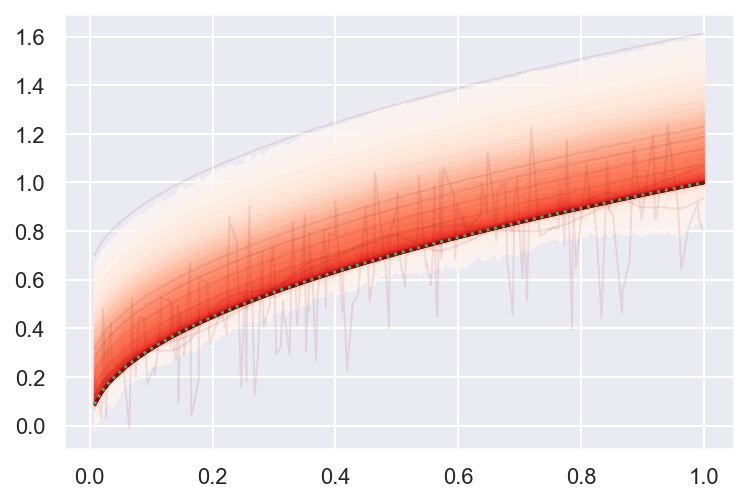

In [139]:
fig, ax = plt.subplots()
plot_gp_dist(ax, f_samples, X)
# ax.plot(X, u_model(X, theta=theta_model), ls="--");
ax.plot(X, u_data(X, theta=theta_data), ls=':', color="C2");

# Sparse

In [223]:
%%stan -f sparse_gp_model.stan -v sparse_model --stanc ~/.cmdstan/cmdstan-2.26.1/bin/stanc
functions {
  vector u_pow(vector x, real theta) {
    return pow(x, theta); 
  }
} 

data {
  int<lower=0> N;
  int<lower=0> N_y;
  vector<lower=0, upper=1>[N] p;
  vector[N] X;
  int<lower=0, upper=1> y[N_y];
  int belong0[N_y];
  int belong1[N_y];
  real theta;
  real tau;
  real jitter;
  int M;
  int<lower=0, upper=1> u_model_index;
}
transformed data {
  matrix[M, M] diag_jitter;
  diag_jitter = diag_matrix(rep_vector(jitter, M));
}
parameters {
  real<lower=0> kernel_length;
  real<lower=0> kernel_var; 
  vector[M] eta;
  vector<lower=0, upper=1>[M] Xm;
}
transformed parameters{
}
model {
  vector[N] seu;
  vector[N_y] seu0;
  vector[N_y] seu1;
  vector[N] Mp;
  vector[N] f_predict;
  vector[N_y] diff_eu;
  matrix[M, M] L;
  matrix[M, M] K;
  vector[M] f;
  matrix[M, N] K_mp;
  vector[M] Mm;
  vector[M] L_dot_eta;
  matrix[M, N] A;
  vector[M] v;
  
  kernel_length ~ normal(0, 1);
  kernel_var ~ normal(0, 1);
  eta ~ std_normal();
  Xm ~ uniform(0, 1);

  K = gp_exp_quad_cov(to_array_1d(Xm), kernel_var, kernel_length) + diag_jitter;
  L = cholesky_decompose(K);

  // if (u_model_index == 0) {
  Mm = Xm;
  Mp = X;
  //}
  // else if (u_model_index == 1) {
  // Mm = u_pow(Xm, theta);
  // Mp = u_pow(X, theta);
  // }
  // else
  //  reject("u_model_index incorrect", u_model_index);

  L_dot_eta = L*eta;
  f = Mm + L_dot_eta;

  K_mp = gp_exp_quad_cov(to_array_1d(Xm), to_array_1d(X), kernel_var, kernel_length);
  A = mdivide_left_tri_low(L, K_mp);
  v = mdivide_left_tri_low(L, L_dot_eta);

  f_predict = Mp + A' * v;

  seu = p .* f_predict;
  seu0 = seu[belong0];
  seu1 = seu[belong1];
  diff_eu = seu1 - seu0;
  y ~ bernoulli_logit(tau * diff_eu);
}
generated quantities {
}

Using stanc compiler:  ~/.cmdstan/cmdstan-2.26.1/bin/stanc
~/.cmdstan/cmdstan-2.26.1/bin/stanc --o=/var/folders/yg/spp3n_c56vxbgvjy9wthwy_h0000gn/T/41df2b95-9f96-4435-a98d-6172e97bc788.cpp sparse_gp_model.stan

-------------------------------------------------------------------------------
Model compiled successfully. Output stored in sparse_model object.
Type sparse_model in a cell to see a nicely formatted code output in a notebook
     ^^^^^^^^^^^^
Access model compile output properties
sparse_model.model_file -> Name of stan_file [sparse_gp_model.stan]
sparse_model.model_name -> Name of stan model [sparse_gp_model_model]
sparse_model.model_code -> Model code [functions {   vector ....]


In [224]:
def prepare_data_for_stan_sparse(data):
    
    p0 = data.p0.values
    p1 = data.p1.values
    x0 = data.x0.values
    x1 = data.x1.values
    y = data.choices.values

    x = np.hstack((x0, x1))
    p = np.hstack((p0, p1))

    x_order = np.argsort(x)
    x_sorted = x[x_order]
    p_sorted = p[x_order]
    undo_sorted = np.argsort(x_order)

    return {
        'tau': tau_data,
        'theta': theta_data,
        'p': p_sorted,
        'X': x_sorted,
        'y': y,
        'N_y': len(y),
        'N': len(x),
        'jitter': 1e-06,
        'belong0': undo_sorted[:len(y)] + 1,
        'belong1': undo_sorted[len(y):] + 1,
        'M': 100,
        'u_model_index': 0
    } 

In [225]:
stan_sparse_data = prepare_data_for_stan_sparse(data)

In [226]:
stan_sparse_model = stan.CmdStanModel(stan_file=sparse_model.model_file)

In [ ]:
trace = stan_sparse_model.sample(data=stan_sparse_data, show_progress="notebook", chains=2)

Chain 1 - warmup:   0%|          | 0/1 [00:00<?, ?it/s]

Chain 2 - warmup:   0%|          | 0/1 [00:00<?, ?it/s]

In [ ]:
samples_az = az.from_cmdstanpy(trace)